In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results/harem-ft_ELMo
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN
/media/discoD/models/elmo/ner/results/harem_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for harem_ELMo+CNN+Embeddings_wang2vec_cbow_3_0
99
99


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo', '0', '0']
['harem-ft', 'ELMo', '1', '0']
['harem-ft', 'ELMo', '2', '0']
['harem-ft', 'ELMo+CNN', '0', '0']
['harem-ft', 'ELMo+CNN', '1', '0']
['harem-ft', 'ELMo+CNN', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'glove', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '1', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '2', '0']
['harem-ft', 'ELMo+CNN+Embeddings', 'wang2v

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 3]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo_0_0,harem-ft,ELMo,No,No,0,0,11,20,00:46:22,2782.0,139.10,0.998377,0.998466,0.981112,0.980583,0.980847,3.849414,0.980111,0.982188,0.823232,0.831633,0.827411,62.998245,0.978612,0.980188,0.829522,0.799332,0.814147,77.248705
1,harem-ft_ELMo_1_0,harem-ft,ELMo,No,No,1,0,12,20,00:22:47,1367.0,68.35,0.997897,0.998055,0.978373,0.973635,0.975998,3.954796,0.989643,0.990540,0.879177,0.892950,0.886010,35.350330,0.978402,0.980203,0.823936,0.795326,0.809378,83.973366
2,harem-ft_ELMo_2_0,harem-ft,ELMo,No,No,2,0,13,20,00:19:09,1149.0,57.45,0.998137,0.998262,0.977649,0.976302,0.976975,3.855790,0.984376,0.985047,0.847082,0.893843,0.869835,59.390949,0.978462,0.980068,0.829060,0.809683,0.819257,83.609045
3,harem-ft_ELMo+CNN_0_0,harem-ft,ELMo+CNN,No,No,0,0,16,20,00:29:28,1768.0,88.40,0.998086,0.998276,0.977568,0.975458,0.976512,3.587718,0.980767,0.983281,0.831266,0.854592,0.842767,82.332504,0.978867,0.980443,0.820000,0.807679,0.813793,93.089778
4,harem-ft_ELMo+CNN_1_0,harem-ft,ELMo+CNN,No,No,1,0,17,20,00:25:10,1510.0,75.50,0.997874,0.998078,0.977640,0.976325,0.976982,4.509836,0.988150,0.989146,0.882199,0.879896,0.881046,41.372279,0.978702,0.980398,0.827420,0.802003,0.814513,92.398115
5,harem-ft_ELMo+CNN_2_0,harem-ft,ELMo+CNN,No,No,2,0,10,20,00:20:42,1242.0,62.10,0.998080,0.998262,0.976821,0.975475,0.976148,3.891977,0.985623,0.986773,0.865702,0.889597,0.877487,50.753713,0.978822,0.980728,0.846044,0.788982,0.816517,79.524829
6,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,0,0,11,20,00:25:16,1516.0,75.80,0.997089,0.997336,0.968091,0.965480,0.966784,5.961578,0.980658,0.982953,0.822055,0.836735,0.829330,62.950836,0.977771,0.979572,0.819931,0.796661,0.808129,70.118833
7,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_1_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,1,0,10,20,00:47:02,2822.0,141.10,0.996483,0.996811,0.964025,0.958838,0.961424,6.172601,0.989743,0.990739,0.886010,0.892950,0.889467,28.274580,0.978191,0.980023,0.824880,0.803673,0.814138,66.954131
8,harem-ft_ELMo+CNN+Embeddings_fasttext_cbow_2_0,harem-ft,ELMo+CNN+Embeddings,fasttext,cbow,2,0,14,20,00:21:14,1274.0,63.70,0.997115,0.997388,0.967840,0.961973,0.964898,6.039752,0.984856,0.985623,0.851020,0.885350,0.867846,43.399102,0.978537,0.980143,0.821138,0.809349,0.815201,69.283380
9,harem-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0,harem-ft,ELMo+CNN+Embeddings,fasttext,skip,0,0,18,20,00:24:52,1492.0,74.60,0.998690,0.998836,0.985672,0.983279,0.984474,2.842341,0.979128,0.980876,0.816626,0.852041,0.833958,94.846123,0.978912,0.980428,0.826356,0.804007,0.815028,102.920017


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:25:44.083333'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,48.0,81.403419,0.403138,79.877217,0.811638,0.814384,0.816316,82.078365
Não,48.0,81.115448,0.565317,79.414298,0.807428,0.811757,0.814589,82.436070


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo,6.0,81.345226,0.409298,80.842322,0.810355,0.813717,0.815703,81.925676
ELMo+Vetor,42.0,81.288771,0.554720,79.836929,0.810452,0.813971,0.816027,82.436070
ELMo+CNN+Vetor,42.0,81.239341,0.424092,80.208860,0.809891,0.812346,0.815461,82.229846
ELMo+CNN,6.0,81.108930,0.847113,79.414298,0.812232,0.814153,0.815522,81.651693


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,36.0,81.396903,0.442442,80.479863,0.811520,0.814087,0.816386,82.436070
Sem Vetor,24.0,81.314140,0.546440,79.414298,0.812893,0.814339,0.816263,81.925676
CBoW,36.0,81.085493,0.509583,79.836929,0.807602,0.811080,0.814564,82.029527


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
Wang2Vec,24.0,81.513345,0.464527,80.722485,0.811984,0.815278,0.817951,82.436070
GloVe,12.0,81.401203,0.436168,80.208860,0.813679,0.815104,0.816457,81.825810
Sem Vetor,12.0,81.227078,0.646187,79.414298,0.811128,0.813970,0.815949,81.925676
FastText,24.0,81.111689,0.356545,80.182156,0.808600,0.811519,0.814109,81.656606
Word2Vec,24.0,81.098561,0.556789,79.836929,0.807309,0.812187,0.814564,82.020202


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           3.0  81.886407   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           3.0  81.781096   
                                     CBoW                3.0  81.685474   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           3.0  81.648451   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram           3.0  81.644310   
                           GloVe     Sem Vetor           3.0  81.603082   
            ELMo+CNN       Sem Vetor Sem Vetor           3.0  81.494114   
Não         ELMo+Vetor     GloVe     Sem Vetor           3.0  81.481136   
Sim         ELMo+CNN+Vetor Wang2Vec  CBoW                3.0  81.467378   
                           FastText  Skip-Gram           3.0  81.437193   
            ELMo           Sem Vetor Sem Vetor           3.0  81.426073   
            ELMo+CNN+Vetor GloVe     Sem Vetor           3.0  81.416086   
                           Wang2Vec  Skip-Gram           3.0  81.389667   
                           Word2Vec  Skip-Gram           3.0  81.336302   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           3.0  81.279741   
            ELMo           Sem Vetor Sem Vetor           3.0  81.264378   
Sim         ELMo+Vetor     FastText  CBoW                3.0  81.261471   
            ELMo+CNN+Vetor Word2Vec  CBoW                3.0  81.251883   
                           FastText  CBoW                3.0  81.248933   
Não         ELMo+Vetor     Wang2Vec  CBoW                3.0  81.233882   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram           3.0  81.172634   
Sim         ELMo+Vetor     FastText  Skip-Gram           3.0  81.169628   
Não         ELMo+CNN+Vetor GloVe     Sem Vetor           3.0  81.104509   
            ELMo+Vetor     Word2Vec  Skip-Gram           3.0  81.020362   
            ELMo+CNN+Vetor Wang2Vec  CBoW                3.0  81.014403   
            ELMo+Vetor     FastText  Skip-Gram           3.0  80.997041   
            ELMo+CNN+Vetor FastText  CBoW                3.0  80.956563   
            ELMo+Vetor     Word2Vec  CBoW                3.0  80.893949   
Sim         ELMo+Vetor     Word2Vec  CBoW                3.0  80.842020   
Não         ELMo+CNN       Sem Vetor Sem Vetor           3.0  80.723745   
            ELMo+CNN+Vetor Word2Vec  CBoW                3.0  80.627026   
            ELMo+Vetor     FastText  CBoW                3.0  80.542941   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
Não         ELMo+Vetor     Wang2Vec  Skip-Gram           0.495494  81.474037   
Sim         ELMo+Vetor     Wang2Vec  Skip-Gram           0.432395  81.285059   
                                     CBoW                0.317430  81.403982   
Não         ELMo+CNN+Vetor Wang2Vec  Skip-Gram           0.526073  81.205312   
Sim         ELMo+Vetor     Word2Vec  Skip-Gram           0.369549  81.281449   
                           GloVe     Sem Vetor           0.207021  81.416538   
            ELMo+CNN       Sem Vetor Sem Vetor           0.141140  81.379310   
Não         ELMo+Vetor     GloVe     Sem Vetor           0.145927  81.350806   
Sim         ELMo+CNN+Vetor Wang2Vec  CBoW                0.486939  80.927399   
                           FastText  Skip-Gram           0.258532  81.152181   
            ELMo           Sem Vetor Sem Vetor           0.494026  80.937819   
            ELMo+CNN+Vetor GloVe     Sem Vetor           0.381437  80.977079   
                           Wang2Vec  Skip-Gram           0.543308  80.767272   
                           Word2Vec  Skip-Gram           0.276719  81.025119   
Não         ELMo+CNN+Vetor FastText  Skip-Gram           0.132690  81.151566   
            ELMo           Sem Vetor Sem Vetor           0.393879  80.842322   
Sim         ELMo+Vetor     FastText  CBoW                0.35

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
wang2vec  skip             12.0  0.816764  0.004693  0.807673  0.814268   
glove     No               12.0  0.814012  0.004362  0.802089  0.813679   
wang2vec  cbow             12.0  0.813503  0.004158  0.807225  0.810891   
word2vec  skip             12.0  0.812934  0.004505  0.804799  0.810574   
No        No               12.0  0.812271  0.006462  0.794143  0.811128   
fasttext  skip             12.0  0.812209  0.002625  0.807308  0.811333   
          cbow             12.0  0.810025  0.004134  0.801822  0.807952   
word2vec  cbow             12.0  0.809037  0.006020  0.798369  0.806318   

                               50%       75%       max  
Embedding Embedding_Type                                
wang2vec  skip            0.816909  0.820045  0.824361  
glove     No              0.815104  0.816457  0.818258  
wang2vec  cbow            0.813971  0.816069  0.820295  
word2vec  skip            0.813445  0.815739  0.820202  
No        No              0.813970  0.815949  0.819257  
fasttext  skip            0.812153  0.814116  0.816566  
          cbow            0.809672  0.813850  0.815458  
word2vec  cbow            0.810392  0.813836  0.816147

In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,12.0,0.816764,0.004693,0.807673,0.814268,0.816909,0.820045,0.824361
glove,12.0,0.814012,0.004362,0.802089,0.813679,0.815104,0.816457,0.818258
word2vec,12.0,0.812934,0.004505,0.804799,0.810574,0.813445,0.815739,0.820202
No,12.0,0.812271,0.006462,0.794143,0.811128,0.813970,0.815949,0.819257
fasttext,12.0,0.812209,0.002625,0.807308,0.811333,0.812153,0.814116,0.816566


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,12.0,0.814012,0.004362,0.802089,0.813679,0.815104,0.816457,0.818258
wang2vec,12.0,0.813503,0.004158,0.807225,0.810891,0.813971,0.816069,0.820295
No,12.0,0.812271,0.006462,0.794143,0.811128,0.813970,0.815949,0.819257
fasttext,12.0,0.810025,0.004134,0.801822,0.807952,0.809672,0.813850,0.815458
word2vec,12.0,0.809037,0.006020,0.798369,0.806318,0.810392,0.813836,0.816147


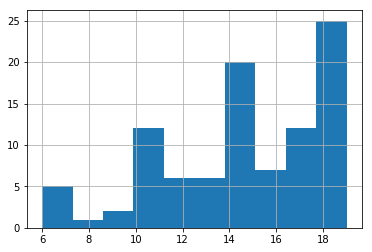

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count      96.000000
mean     1544.083333
std       381.634178
min      1149.000000
25%      1363.250000
50%      1451.500000
75%      1578.750000
max      2908.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
2,32.0,0.813305,0.004511,0.798772,0.812415,0.814132,0.816253,0.820784
1,32.0,0.812821,0.004578,0.802089,0.809233,0.813831,0.816024,0.822298
0,32.0,0.811657,0.006060,0.794143,0.808350,0.812452,0.814475,0.824361


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,96.0,0.812594,0.005094,0.00052,0.811562,0.813626


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,12,0.812271,0.006462,0.001865,0.808615,0.815927
fasttext,24,0.811117,0.003565,0.000728,0.809690,0.812543
glove,12,0.814012,0.004362,0.001259,0.811544,0.816480
wang2vec,24,0.815133,0.004645,0.000948,0.813275,0.816992
word2vec,24,0.810986,0.005568,0.001137,0.808758,0.813213


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 91) =  3.088, p =  0.01965643427704087676
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.088
Date:                Thu, 30 May 2019   Prob (F-statistic):             0.0197
Time:                        08:45:05   Log-Likelihood:                 377.25
No. Observations:                  96   AIC:                            -744.5
Df Residuals:                      91   BIC:                            -731.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------